In [ ]:
# General comments and considerations

In [2]:
# general stuff
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os,re
import time
import nibabel as nib
from subprocess import Popen, PIPE
from os.path import join as opj
import math

# sklearn stuff
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import scale
import sklearn.metrics.cluster as metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster.hierarchical import _hc_cut # Internal function to cut ward tree, helps speed up things a lot
from sklearn.utils import resample
from sklearn.model_selection import KFold

# personal functions
from importlib import reload
import myutils as mu
reload(mu)

if os.path.exists('/data1/vbeliveau/'):
    # On NRU server
    cluster_code='/data1/vbeliveau/5HT_clustering'
    cluster_data='/data1/vbeliveau/5HT_clustering_data'
    subjects_dir='/usr/local/nru/freesurfer/subjects'
elif os.path.exists('C:/Users/vbeliveau/'):
    # On laptop
    cluster_code='C:/Users/vbeliveau/Documents/GitHub/5HT_clustering'
    cluster_data='C:/Users/vbeliveau/Downloads/5HT_clustering_data'
    subjects_dir='C:/Users/vbeliveau/Downloads/'
else:
    raise ValueError('Unknow location')
    
# Analysis directories
surf_data=opj(cluster_data,'surf_data')
mu.assert_dir(surf_data)
BPnd_data=opj(cluster_data,'BPnd')
mu.assert_dir(BPnd_data)
MFA_data=opj(cluster_data,'MFA')
MFA_preproc=opj(MFA_data,'preproc')
mu.assert_dir(MFA_data)
mu.assert_dir(MFA_preproc)

info_path=opj(cluster_code,'info_alltracers_base_healthy_hrrt.mat')
hemi_type=['lh','rh']

info=sio.loadmat(info_path)
tracers=['cumi','dasb','sb','az','C36']
petID=[item for subl in info['petID'] for subsubl in subl for item in subsubl]

In [54]:
# Create cortex masks

hemi_type=['lh','rh']
targ_list=['fsaverage5']

for targ in targ_list:
    for hemi in hemi_type:
        mu.fs_create_cortex_mask(subjects_dir,targ,hemi,validate=True,verbose=True,
                                 save_out=opj(surf_data,'mask.'+targ+'.'+hemi))

Reading C:/Users/vbeliveau/Downloads/fsaverage5\surf\lh.pial
10000/10242
Validating cortex mask
Saving file C:/Users/vbeliveau/Downloads/5HT_clustering_data\surf_data\mask.fsaverage5.lh
Reading C:/Users/vbeliveau/Downloads/fsaverage5\surf\rh.pial
10000/10242
Validating cortex mask
Saving file C:/Users/vbeliveau/Downloads/5HT_clustering_data\surf_data\mask.fsaverage5.rh


In [75]:
# Create neighbor lists

hemi_type=['lh','rh']
targ_list=['fsaverage5']

for targ in targ_list:
    for hemi in hemi_type:
        save_out=opj(surf_data,'neigh.'+targ+'.'+hemi)
        mu.fs_surf_neighborhood(opj(subjects_dir,targ,'surf',hemi+'.pial'),mask=fmask,
                                verbose=True, out_type='matrix',save_out=save_out)

Reading C:/Users/vbeliveau/Downloads/fsaverage5\surf\lh.pial
Saving file C:/Users/vbeliveau/Downloads/5HT_clustering_data\surf_data\neigh.fsaverage5.lh.matrix
Reading C:/Users/vbeliveau/Downloads/fsaverage5\surf\rh.pial
Saving file C:/Users/vbeliveau/Downloads/5HT_clustering_data\surf_data\neigh.fsaverage5.rh.matrix


In [ ]:
# Sample TACs to fsaverage surface

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
hemi_type=['lh','rh']
targ='fsaverage5'
smooth=['0','5','10']

import_pet='/data1/vbeliveau/atlas/import/PET'
proc_pet='/data2/FSproc/PET'

for tracer in tracers:
    
    dest=opj(MFA_data,'surf_tacs')
    mu.assert_dir(dest)
    tracer_dest=opj(dest,tracer)
    mu.assert_dir(tracer_dest)
    log_dest=opj(tracer_dest,'log')
    mu.assert_dir(log_dest)
        
    subjlist=[item for item in petID if re.search('^'+tracer+'.*',item) is not None]
    
    for subj in subjlist:
        for hemi in hemi_type:
            for sm in smooth:

                mov=opj(import_pet,subj,'tac.realigned.nii.gz')
                reg=opj(proc_pet,subj,'tac.realigned.wavg.GD.lta')
                out=opj(tracer_dest,subj + '.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
                cmd=['mri_vol2surf','--mov',mov,'--reg',reg,'--hemi',hemi,'--o',out,
                            '--trgsubject',targ,'--projfrac','0.5','--cortex']
                if sm != '0':
                    cmd.append('--surf-fwhm')
                    cmd.append(sm)

                log_file=open(opj(log_dest,'mri_vol2surf.' + subj + '.' + hemi + '.sm' +  sm + '.log'),'w')
                p=Popen(cmd, stdout=log_file, stderr=log_file)
                p.communicate() # This makes sure we wait for command to be executed before moving on
                log_file.close()

In [36]:
# Preprocess the raw data for MFA

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
targ='fsaverage5'
smooth=['0','5','10']

for tracer in tracers:
    hemi_mask={}
    subjlist=[item for item in petID if re.search('^'+tracer+'.*',item) is not None]
    data_scaled=np.ndarray([len(subjlist)],dtype=object)
    eig1=np.empty(len(subjlist))
    for sm in smooth:
        for ns in np.arange(0,len(subjlist)):
            data=None
            valid_frames=np.ndarray(0,dtype=int)
            for hemi in hemi_type:
                fmask=opj(surf_data,'mask.'+targ+hemi)
                data=np.vstack(data,
                            mu.fs_load_surf_data(opj(MFA_data,'surf_tacs',tracer,subjlist[ns] + '.' +
                                 hemi + '.' + targ + '.sm' + sm + '.nii.gz'),
                            mask=fmask))

                # Identify empty frames in current hemisphere, and compare to other hemisphere
                hemi_frames=np.sum(img,axis=0).flatten()>10000 # Here 10000 is a little random, any better test?            
                if np.sum(hemi_frames)<np.sum(valid_frames):
                    valid_frames=hemi_frames

            # Select valid frames, Scale data (mean=0 and var=1, row-wise) and compute first eigenval
            data_scaled[ns]=scale(data[:,valid_frames],axis=1)
            eig1[ns]=np.linalg.svd(data_scaled[ns],compute_uv=False)[0]

        # Save out results
        np.savez(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm), data_scaled, eig1)

# The following warning was issued when running for the first time, but didn't appear when rerunning.
# Will need to investigate further...
# /data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
#   warnings.warn("Numerical issues were encountered "
# /data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
#   warnings.warn("Numerical issues were encountered "

/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [151]:
# Create surface maps of MFA weights and plot eigenvalue, for a range of smoothness levels

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
smooth=['0','5','10']

Kmax=10 # Maximum number of components to consider
svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')

plot_eigs=True
save_maps=True
dest=opj(MFA_data,'weights')
mu.assert_dir(dest)

for tracer in tracers:
    if plot_eigs:
        nplt=0
        plt.figure(figsize=(10,2))
    for sm in smooth:
        # Load the data
        preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
        data=preproc['arr_0']
        eig1=preproc['arr_1']
        N=len(data)

        # Divide all datasets by first eigenval
        for ns in np.arange(0,N):
            data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities

        # Perform SVD
        svd.fit(np.transpose(np.hstack(data)))
        U=np.transpose(svd.components_)
        S=np.linalg.svd(np.hstack(data),full_matrices=False,compute_uv=False)
        if plot_eigs:
            nplt=nplt+1
            plt.subplot(1,len(smooth),nplt)
            plt.plot(np.arange(1,Kmax+1),S[0:Kmax])
            plt.title(tracer + ', sm' + sm)
            
        if save_maps: # Save weights out as surface overlay
            fname=opj(dest,tracer + '.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
            fmask=[opj(surf_data,targ,hemi) for hemi in hemi_type]
            mu.fs_save_surf_data(U,fname,mask=fmask,verbose=True)
    if plot_eigs:
        plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/vbeliveau/Downloads/5HT_clustering_data\\surf_data\\fsaverage5\\lh.npz'

In [ ]:
# Compare components obtained with SVD and truncated SVD
# Here PCA is used as the gold standard (full, accurate decomposition)
# and truncated SVD is performed with some variations

from sklearn.decomposition import PCA

tracer='cumi'
preproc=np.load(opj(MFA_data,tracer,'preproc.fsaverage5.sm5.npz'))
data=preproc['arr_0']
data=np.hstack(data) # Use whole dataset

Kmax=20
U,S,V=np.linalg.svd(data,full_matrices=False)

def print_corr(A,B,Kmax):
    for i in np.arange(0,Kmax):
        cc=np.zeros(Kmax)
        for j in np.arange(0,Kmax):
            cc[j]=abs(np.dot(np.transpose(A[:,i]),B[:,j]))
        print('Component ' + str(i+1) + ': %f' % np.max(cc))
    
# Trunk SVD from PCA
print('Truncated SVD with PCA')
pca=PCA(n_components=Kmax)
pca.fit(np.transpose(data))
print_corr(np.transpose(pca.components_),U,Kmax)

# Trunk SVD from TruncatedSVD with random the randomized algorithm (default)
print('\nTruncated SVD with randomized')
svd1=TruncatedSVD(n_components=Kmax)
svd1.fit(np.transpose(data))
print_corr(np.transpose(svd1.components_),U,Kmax)

# Trunk SVD from TruncatedSVD with ARPACK algorithm
print('\nTruncated SVD with ARPACK')
svd2=TruncatedSVD(n_components=Kmax,algorithm='arpack')
svd2.fit(np.transpose(data))
print_corr(np.transpose(svd2.components_),U,Kmax)

In [ ]:
# Perform bootstrap of the MFA components to obtain an estimate of each component at the vertice level
# The goal here is to identify components containing significant "structures", and keep those components

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
targ='fsaverage5'
sm='5'

Niter=500 # Number of iterations (usually ~1000 or 10000)
Nupdate=50 # Number of iteration for verbose update
Kmax=10 # Maximum number of components to consider

conf=0.025

for tracer in tracers:
    
    # Load the data
    preproc=np.load(opj(MFA_data,tracer,'preproc.' + targ + '.sm' + sm + '.npz'))
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    N=data.shape[0]
    Nvert=data[0].shape[0]
    
    # Divide all datasets by first eigenval
    for ns in np.arange(0,N):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities
        
    svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')
    svd.fit(np.transpose(np.hstack(data)))
    U=np.transpose(svd.components_)
    S=np.linalg.svd(np.hstack(data), full_matrices=False, compute_uv=False)
    
    Zboot=np.ndarray([Nvert,Niter,Kmax])
    Sboot=np.ndarray([Kmax,Niter])
    start_t = time.time()
    if (Nupdate>0):
        print('Processing ' + tracer)
    for ni in np.arange(0,Niter): # Will need to parallelize this

        if (Nupdate>0 and ni % Nupdate == 0):
            print('Iter ' + str(ni))    
        
        # Get indices for current fold
        ind=resample(np.arange(0,N),replace=True)
        
        # Perform SVD and compute
        svd.fit(np.transpose(np.hstack(data[ind])))
        src_ind,_,Uboot=balance_svd_components(U,np.transpose(svd.components_),return_balanced=True)
        Zboot[:,ni,:]=scale(Uboot)
        Sboot[:,ni]=np.linalg.svd(np.hstack(data[ind]), full_matrices=False, compute_uv=False)[src_ind]
            
    # Build 95% confidence interval and find if 0 is within the interval at each vertice
    sig=np.empty([Nvert,Kmax])
    for nk in np.arange(0,Kmax):
        Zboot[:,:,nk]=np.sort(Zboot[:,:,nk],axis=1)
        ind=Zboot[:,Niter-1,nk]>0
        nind=np.logical_not(ind)
        sig[ind,nk]=Zboot[ind,int(np.round(Zboot.shape[1]*conf)),nk]>0 # 0 is not in the lower tail
        sig[nind,nk]=Zboot[nind,int(np.round(Zboot.shape[1]*conf)),nk]<0 # 0 is not in the upper tail
                    
    # Save components and eigval
    np.savez(opj(MFA_data,tracer,'bootstrap.data.' +  targ +'.sm' + sm),Zboot,Sboot,sig)
    
    # Save out mean Z maps and significant vertices as surface overlays
    fmask=[opj(surf_data,targ,hemi) for hemi in hemi_type]
    fname=opj(MFA_data,tracer,'bootstrap.Zmean.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
    mu.fs_save_surf_data( Zboot.mean(axis=1),fname,mask=fmask,verbose=True)
    fname=opj(MFA_data,tracer,'bootstrap.sig.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
    mu.fs_save_surf_data(sig,fname,mask=fmask,verbose=True)

Processing cumi


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


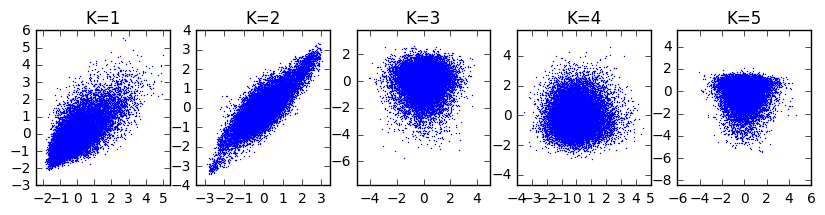

Processing dasb


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


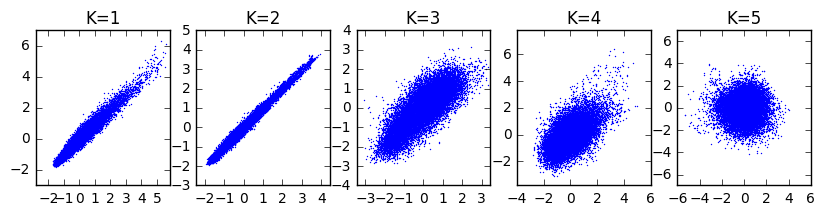

Processing sb


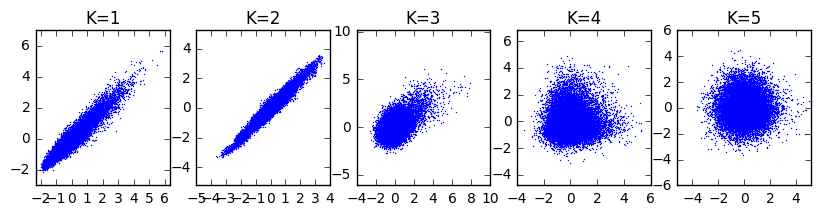

Processing az


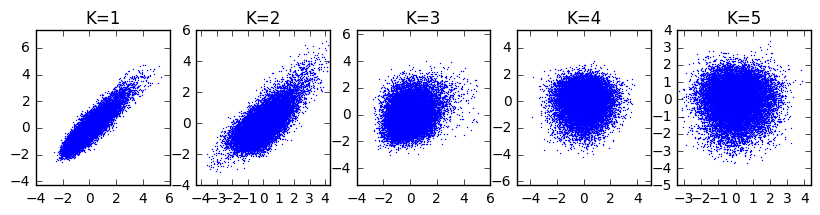

Processing C36


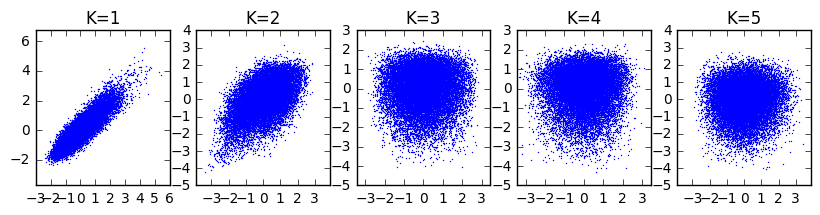

In [36]:
# Perform split-half evaluation the reproducibility of the MFA components

tracers=['cumi','dasb','sb','az','C36']
# tracers=['dasb']
targ='fsaverage5'
sm='5'

Niter=1 # Number of split-half iterations (usually ~1000 or 10000)
Kmax=5 # Maximum number of components to consider

plot_example=True
Nupdate=100

kf=KFold(n_splits=2,shuffle=True) # Split-half model
cc={}
cc_null={}
for tracer in tracers:
    
    # Load the data
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    N=data.shape[0]
    
    # Divide all datasets by first eigenval
    for ns in np.arange(0,N):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities
        
    svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')    
    start_t = time.time()
    print('Processing ' + tracer)
    for ni in np.arange(0,Niter): # Will need to parallelize this

#         if (Nupdate>0 and ni % 100 == 0):
#             print('Iter ' + str(ni)            
        
        # Get indices for current fold
        split1,split2=kf.split(np.arange(0,N))
        
        # Perform SVD on split 1 & 2, separately
        svd.fit(np.transpose(np.hstack(data[split1[0]])))
        U1=scale(np.transpose(svd.components_))
        svd.fit(np.transpose(np.hstack(data[split2[0]])))
        U2=scale(np.transpose(svd.components_))
        [_,_,U2]=mu.balance_svd_components(U1,U2,return_balanced=True)
        
        plt.figure(figsize=(10,2))
        if plot_example:
            for nk in np.arange(0,Kmax):
                plt.subplot(1,Kmax,nk+1)
                plt.scatter(U1[:,nk],U2[:,nk],s=1,lw=0)
                plt.axis('equal')
                plt.title('K=' + str(nk+1))

            plt.show()

In [713]:
# Cluster BPnd maps using Ward's with spatial constraint
# Dimensionality is estimated based on stability metrics in split-half setting
# This will be useful to see if we gain anything knowledge from decomposing the dynamic data

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
# hemi_type=['lh','rh']
hemi_type=['lh']
targ='fsaverage5'
sm='10'
    
convert=True
convert_mean=False
cluster=False
whole_dataset=False

maps_dest=opj(BPnd_data,'maps')
mu.assert_dir(maps_dest)

# Split-half parameters
split_half=True
Krange=np.arange(2,50,1)
kf=KFold(n_splits=2,shuffle=True)
Niter=10
plot_metrics=True

# Perform Ward clustering on BPnd data
for tracer in tracers:
    
    print(tracer)
    
    surf_dest=maps_dest + '/' + tracer    
    mu.assert_dir(surf_dest)
    
    # If BPnd was not preprocessed (e.g. fsaverage5), do it here
    if convert:        
        log_dest=opj(surf_dest,'log')
        mu.assert_dir(log_dest)
        for hemi in hemi_type:
            # Convert BPnd from fsaverage to target
            sval=opj('/data1/vbeliveau/atlas/analyses/bmax_maps/data.nopvc.surf/' + 
                tracer + '.bpnd.mrtm2.nopvc.fsaverage.' + hemi + '.sm' +  sm + '.nii.gz')
            tval=opj(surf_dest,'mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz')

            log_file=open(opj(log_dest,'mri_surf2surf.' + hemi +'.log'),'w')
            p=Popen(['mri_surf2surf','--srcsubject','fsaverage','--trgsubject',targ,
                    '--srchemi',hemi,'--trghemi',hemi,'--sval',sval,'--tval',tval], stdout=log_file, stderr=log_file)
            p.communicate()
            log_file.close()
            
    if convert_mean:
        log_dest=opj(surf_dest,'log')
        mu.assert_dir(log_dest)
        for hemi in hemi_type:
            # Convert BPnd from fsaverage to target
            sval=('/data1/vbeliveau/atlas/analyses/bmax_maps/data.nopvc.surf/' + 
                tracer + '.mean.bpnd.mrtm2.nopvc.fsaverage.' + hemi + '.sm' +  sm + '.nii.gz')
            tval=opj(surf_dest,'mean.mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz')

            log_file=open(opj(log_dest,'mri_surf2surf.mean.' + hemi +'.log'),'w')
            p=Popen(['mri_surf2surf','--srcsubject','fsaverage','--trgsubject',targ,
                    '--srchemi',hemi,'--trghemi',hemi,'--sval',sval,'--tval',tval], stdout=log_file, stderr=log_file)
            p.communicate()
            log_file.close()
                                            
    if cluster: # Estimate cluster number using stability metrics in split-half
        
        for hemi in hemi_type:
            fname=opj(surf_dest,'mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz')
            fmask=opj(surf_data,'mask.'+targ+','+hemi)
            img=mu.fs_load_surf_data(fname,mask=fmask)

            # Import adjacency matrix
            fneigh=opj(surf_data,'neigh.'+targ+'.'+hemi+'.matrix')
            A,_=mu.fs_load_surf_neighborhood(fneigh)
            
            # Scale the data
            data_scaled=scale(data,axis=0)
            
            # Cluster the whole dataset for a range of K
            if whole_dataset:
                ward_labels=np.zeros([data_scaled.shape[0],len(Krange)])
                for nk in np.arange(0,len(Krange)):
                    mdl=AgglomerativeClustering(n_clusters=Krange[nk], connectivity=Amask,linkage='ward')
                    mdl.fit(data_scaled)
                    ward_labels[:,nk]=mdl.labels_+1

                # Save the clustering out as surface overlay
                fname=opj(surf_dest,'ward.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz')
                mu.fs_save_surf_data(fname,mask=fmask)

            # Evaluate clustering stability for a range of K
            if split_half:
                ars=np.empty([Niter,len(Krange)])
                ami=np.empty([Niter,len(Krange)])
                mdl1=AgglomerativeClustering(compute_full_tree=True, connectivity=A,linkage='ward')
                mdl2=AgglomerativeClustering(compute_full_tree=True, connectivity=A,linkage='ward')
                for ni in np.arange(0,Niter):
                    # Fit data
                    split1,split2=kf.split(np.arange(0,N))                    
                    mdl1.fit(data_scaled[:,split1[0]])
                    mdl2.fit(data_scaled[:,split2[0]])
                    
                    for nk in np.arange(0,len(Krange)):
                        # Cut trees
                        # NOTE: labels start at 0, so add one to distinguish from medial wall
                        labels1=_hc_cut(nk,mdl1.children_,mdl1.n_leaves_)+1 
                        labels2=_hc_cut(nk,mdl2.children_,mdl2.n_leaves_)+1
                        
                        # Compute metrics
                        ars[ni,nk]=metrics.adjusted_rand_score(labels1, labels2)
                        ami[ni,nk]=metrics.adjusted_mutual_info_score(labels1, labels2)
                                                
#                 np.savez(surf_dest + '/ward.metrics.' + targ + '.' + hemi + '.sm' + sm,ars,ami,nmi,Krange)

                if plot_metrics:
                    print(tracer)
                    plt.figure(figsize=(8,2))
                    plt.subplot(1,2,1)
                    plt.plot(Krange,ars.mean(axis=0))
                    plt.title('Adjusted Rand Index')
                    plt.subplot(1,2,2)
                    plt.plot(Krange,ami.mean(axis=0))
                    plt.title('Adjusted Mutual Information')
                    plt.show()

cumi
dasb
sb
az
C36


In [47]:
fmask=opj(surf_data,'mask.fsaverage5.lh')
mask,_,N=mu.fs_load_mask(fmask)
mask

array([ 112,  114,  247, ..., 9279, 9280,   22])

cumi


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


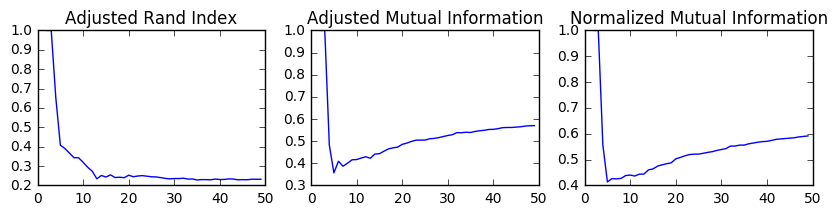

dasb


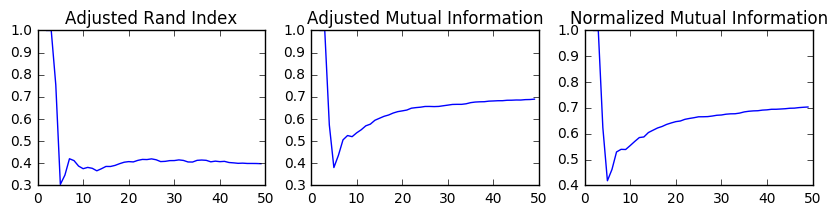

sb


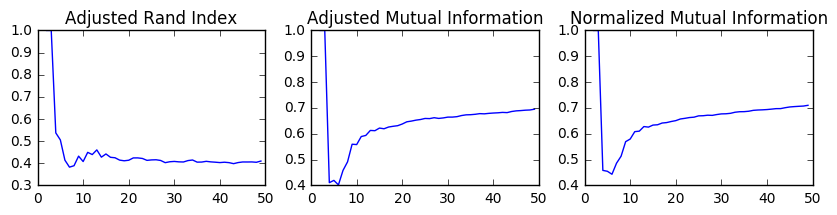

az


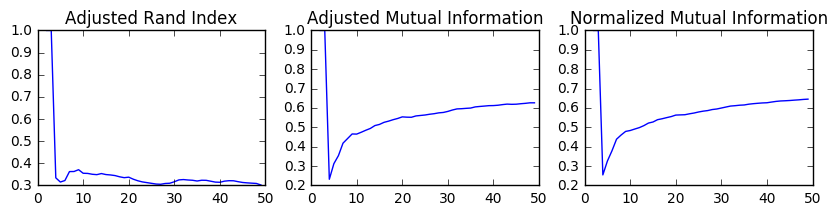

C36


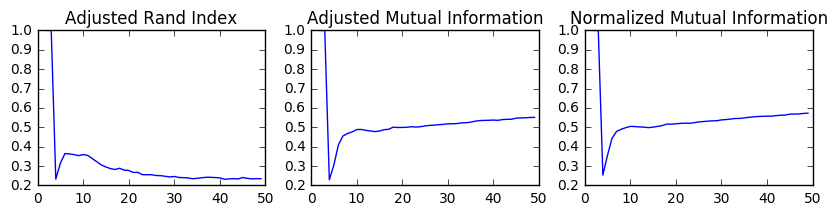

In [59]:
# Cluster MFA components using Ward's with spatial constraint
# Dimensionality is estimated based on stability metrics in split-half setting

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
# hemi_type=['lh','rh']
hemi_type=['lh']
targ='fsaverage5'
sm='10'

Kopt={'cumi': 2, 'dasb': 3,'sb': 2, 'az': 2,'C36': 1}

dest=opj(cluster_data,'MFA')
mu.assert_dir(dest)
    
convert=False  
cluster=True
whole_dataset=False

# Split-half parameters
split_half=True
Krange=np.arange(2,50,1)
kf=KFold(n_splits=2,shuffle=True)
Niter=10
plot_metrics=True

# Perform Ward clustering on MFA components
for tracer in tracers:

    print(tracer)
    
    surf_dest=dest + '/' + tracer    
    mu.assert_dir(surf_dest)

    # Define SVD model
    svd=TruncatedSVD(n_components=Kopt[tracer],algorithm='arpack')
    
    # Load the data
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    
    # Divide all datasets by first eigenval
    for ns in np.arange(0,N):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities
        
    # Preload adjacency matrix (might need to modify this if they can't be held in memory)
    N={}; mdl1={}; mdl2={}; ars={}; ami={}
    for hemi in hemi_type:
        # Import adjacency matrix
        fneigh=opj(surf_data,'neigh.'+targ+'.'+hemi+'.matrix')
        A,_=mu.fs_load_surf_neighborhood(fneigh)
        N[hemi]=A.shape[0]
        
        # Clustering models & comparison metrics
        mdl1[hemi]=AgglomerativeClustering(compute_full_tree=True, connectivity=A,linkage='ward')
        mdl2[hemi]=AgglomerativeClustering(compute_full_tree=True, connectivity=A,linkage='ward')
        ars[hemi]=np.empty([Niter,len(Krange)])
        ami[hemi]=np.empty([Niter,len(Krange)])
        nmi[hemi]=np.empty([Niter,len(Krange)])

    for ni in np.arange(0,Niter):

        # Get optimal (Kopt) MFA components (scaled)
        split1,split2=kf.split(np.arange(0,len(data)))
        svd.fit(np.transpose(np.hstack(data[split1[0]])))
        data_scaled1=scale(np.transpose(svd.components_))
        svd.fit(np.transpose(np.hstack(data[split2[0]])))
        data_scaled2=scale(np.transpose(svd.components_))

        nprev=0
        nnext=0
        for hemi in hemi_type:        
            nprev=nnext
            nnext=nprev+N[hemi]

            # Fit data
            mdl1[hemi].fit(data_scaled1[nprev:nnext,:])
            mdl2[hemi].fit(data_scaled2[nprev:nnext,:])

            for nk in np.arange(0,len(Krange)):
                    # Cut trees
                    # NOTE: labels start at 0, so add one to distinguish from medial wall
                    labels1=_hc_cut(nk,mdl1[hemi].children_,mdl1[hemi].n_leaves_)+1 
                    labels2=_hc_cut(nk,mdl2[hemi].children_,mdl2[hemi].n_leaves_)+1

                    # Compute metrics
                    ars[hemi][ni,nk]=metrics.adjusted_rand_score(labels1, labels2)
                    ami[hemi][ni,nk]=metrics.adjusted_mutual_info_score(labels1, labels2)

#                 np.savez(surf_dest + '/ward.metrics.' + targ + '.' + hemi + '.sm' + sm,ars,ami,nmi,Krange)

    for hemi in hemi_type:
        if plot_metrics:
            plt.figure(figsize=(8,2))
            plt.subplot(1,2,1)
            plt.plot(Krange,ars[hemi].mean(axis=0))
            plt.title('Adjusted Rand Index')
            plt.subplot(1,2,2)
            plt.plot(Krange,ami[hemi].mean(axis=0))
            plt.title('Adjusted Mutual Information')
            plt.show()

In [41]:
# Compute gradient map of MFA weights and BPnd

# modalities={'MFA','BPnd'}
modalities={'MFA'}
targ='fsaverage5'
sm='10'
tracers=['cumi']
hemi_type=['lh']

for hemi in hemi_type:
    for tracer in tracers:
        for modality in modalities:
            
            if modality in 'MFA':
                img=nib.load(opj(MFA_data,'weights',tracer + '.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz'))
                dest=opj(MFA_data,'gradient')
                mu.assert_dir(dest)
            if modality in 'BPnd':
                img=nib.load(opj(BPnd_data,'maps',tracer + '/mean.mrtm2.nopvc.' + 
                             targ + '.' + hemi + '.sm' + sm + '.nii.gz'))
                dest=opj(cluster_data,'BPnd','gradient')
                mu.assert_dir(dest)

            data=img.get_data()
            grad=np.ndarray(data.shape,dtype=data.dtype)
            for nk in np.arange(0,data.shape[3]):
                grad[:,nk]=mu.vlen(mu.build_surface_gradient_matrix(data[0,:,0,nk],opj(targ,hemi +'.pial')),axis=1)

            nib.save(nib.Nifti1Image(grad, np.eye(4)), opj(dest,tracer + hemi + '.' + targ + '.sm' + sm + '.nii.gz'))


ValueError: could not broadcast input array from shape (10242) into shape (1,1,10)

[ 0.72153253  0.50796363 -0.47049311]
2.3179176639
132.806899401
[  7.21532530e-01  -1.66533454e-16   6.92380543e-01]


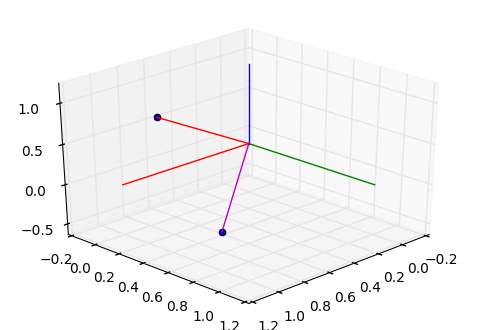

-118.066310013


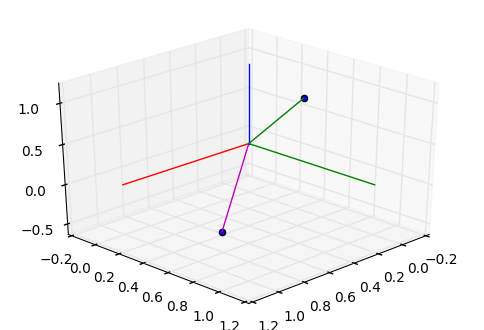

-46.1811540948
[ -5.55111512e-17  -1.66533454e-16   1.00000000e+00]


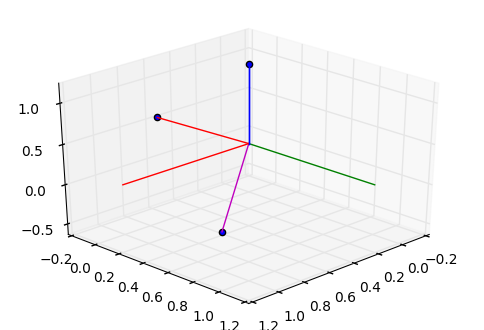

In [132]:
# Testing rotations

v=np.random.normal(size=3)
v=mu.normv(v)
v=np.array([0.72153253,0.50796363,-0.47049311])
print(v)

vx=np.array([1.,0.,0.])
vy=np.array([0.,1.,0.])
vz=np.array([0.,0.,1.])

def plot_axes_vec():
    fig = matplotlib.pyplot.figure()
    h  = fig.add_subplot(111, projection = '3d')
    h.scatter(v[0],v[1],v[2])
    h.plot([0,v[0]],[0,v[1]],[0,v[2]], color = 'm')
    h.plot([0,vx[0]],[0,vx[1]],[0,vx[2]], color = 'r')
    h.plot([0,vy[0]],[0,vy[1]],[0,vy[2]], color = 'g')
    h.plot([0,vz[0]],[0,vz[1]],[0,vz[2]], color = 'b')
    h.view_init(30, 45)
    return h
    
# Rotate along y
rx=mu.vec_angle(vz,np.array([0,v[1],v[2]]))
if v[1]<0:
    rx=-rx
print(rx)
    
print(rx*180/np.pi)
vrx=mu.rotate3d(v,rx,axis=0,compute=True)
print(vrx)

h=plot_axes_vec()
h.scatter(vrx[0],vrx[1],vrx[2])
h.plot([0,vrx[0]],[0,vrx[1]],[0,vrx[2]], color = 'r')
matplotlib.pyplot.show()

# Rotate along y
ry=-mu.vec_angle(vz,v)
print(ry*180/np.pi)
vry=mu.rotate3d(v,ry,axis=1,compute=True)

h=plot_axes_vec()
h.scatter(vry[0],vry[1],vry[2])
h.plot([0,vry[0]],[0,vry[1]],[0,vry[2]], color = 'g')
matplotlib.pyplot.show()

# Rotate along y
ry=mu.vec_angle(vz,vrx)
if vrx[0]>0:
    ry=-ry
print(ry*180/np.pi)
vry=mu.rotate3d(vrx,ry,axis=1,compute=True)
print(vry)

h=plot_axes_vec()
h.scatter(vrx[0],vrx[1],vrx[2])
h.plot([0,vrx[0]],[0,vrx[1]],[0,vrx[2]], color = 'r')
h.scatter(vry[0],vry[1],vry[2])
h.plot([0,vry[0]],[0,vry[1]],[0,vry[2]], color = 'b')
matplotlib.pyplot.show()

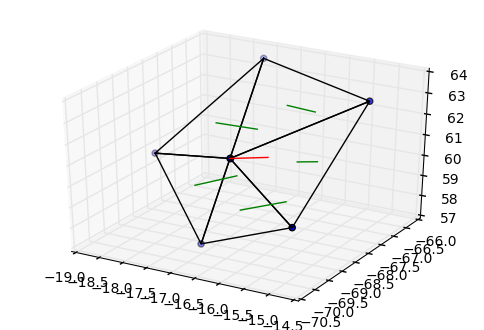

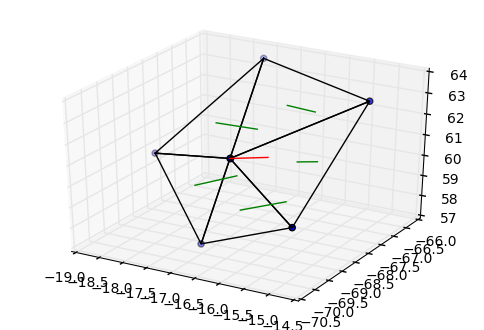

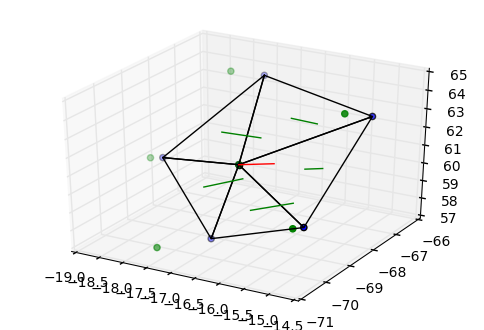

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.87947101e+00   1.85522250e+00   1.11022302e-16]
 [ -8.26753968e-01   3.95434642e+00   6.66133815e-16]
 [  1.69752859e+00  -2.90450579e+00   0.00000000e+00]
 [ -1.30481064e+00  -3.56256092e+00  -4.44089210e-16]
 [ -2.07862826e+00   6.05920219e-01   1.66533454e-16]]


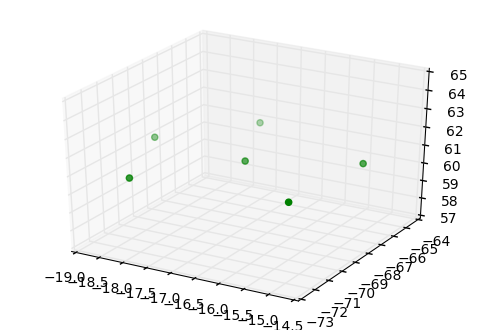

[ 0.          2.6342138   3.96107983  3.31333583  3.75194963  2.15754478]
[        nan  2.64088277  4.03984873  3.36418745  3.79399145  2.16514081]


In [18]:
# Testing normals and projections

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

nv=1 # Select vertice
fname=opj(subjects_dir,'fsaverage5','surf','lh.pial')
faces,position=mu.fs_read_surf(fname)
vertices=np.where(np.sum(faces==nv,axis=1)>=1)[0]

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

faces_ind=np.where(np.sum(faces==nv,axis=1)>=1)[0] # Extract rows for each faces containing the current vertice
pts=np.unique(faces[faces_ind,:])

# Plot triangles contour
for nf in faces_ind:
    x=position[faces[nf,[0,1,2,0]],0]
    y=position[faces[nf,[0,1,2,0]],1]
    z=position[faces[nf,[0,1,2,0]],2]
    ax.plot(x,y,z, color = 'k')
    
# Plot points
ax.scatter(position[pts,0], position[pts,1], position[pts,2])
ax.scatter(position[nv,0], position[nv,1], position[nv,2],c='r')

# Plot normals
midface=np.ndarray([len(faces),3])
fnorm=np.ndarray([len(faces_ind),3])
nn=0
for nf in faces_ind:
    ind=np.where(faces[nf,:]==nv)[0]
    if ind==0:
        fnorm[nn,:]=np.cross(position[faces[nf,2],:]-position[faces[nf,0],:],
                    position[faces[nf,1],:]-position[faces[nf,0],:])
    elif ind==1:
        fnorm[nn,:]=np.cross(position[faces[nf,0],:]-position[faces[nf,1],:],
                        position[faces[nf,2],:]-position[faces[nf,1],:])
    elif ind==2:
        fnorm[nn,:]=np.cross(position[faces[nf,1],:]-position[faces[nf,2],:],
                        position[faces[nf,0],:]-position[faces[nf,2],:])
    midface[nn,:]=position[faces[nf,:],:].mean(axis=0)
    nn=nn+1

fnorm=mu.normm(fnorm,axis=1)
        
for nf in np.arange(0,len(faces_ind)):
    x=[midface[nf,0],midface[nf,0]+fnorm[nf,0]];
    y=[midface[nf,1],midface[nf,1]+fnorm[nf,1]];
    z=[midface[nf,2],midface[nf,2]+fnorm[nf,2]];
    ax.plot(x,y,z, color = 'g')

mfnorm=mu.normv(fnorm.mean(axis=0))
x=[position[nv,0],position[nv,0]+mfnorm[0]];
y=[position[nv,1],position[nv,1]+mfnorm[1]];
z=[position[nv,2],position[nv,2]+mfnorm[2]];
ax.plot(x,y,z,color = 'r')

# Compute and plot project of each point onto the normal plane
proj_pts=np.zeros([len(pts),3])
px=position[pts,:]-position[nv,:]
for pt in np.where(pts!=nv)[0]:
    proj_pts[pt,:]=(px[pt,:]-np.dot(px[pt,:],mfnorm)*mfnorm)
    proj_pts[pt,:]=proj_pts[pt,:]*(mu.norm_arclen(px[pt,:],mfnorm)/mu.vlen(proj_pts[pt,:]))
x=position[nv,0]+proj_pts[:,0];
y=position[nv,1]+proj_pts[:,1];
z=position[nv,2]+proj_pts[:,2];
ax.scatter(x,y,z,color = 'g')
matplotlib.pyplot.show()

# Find rotation of normal vector onto z-axis
ez=np.array([0.,0.,1.])
# Rotate along x-axis
ax=mu.vec_angle(ez,np.array([0,mfnorm[1],mfnorm[2]]))
if mfnorm[1]<0:
    ax=-ax
# Rotate along y-axis
vrx,Rx=mu.rotate3d(mfnorm,ax,axis=0,compute=True,matrix=True)
ay=mu.vec_angle(ez,vrx)
if vrx[0]>0:
    ay=-ay
vz,Ry=mu.rotate3d(vrx,ay,axis=1,compute=True,matrix=True)

# For sanity, check that snorm was well projected onto z-axis
if (not math.isclose(vz[0],0.0, abs_tol=1e-9) or not math.isclose(vz[1],0.0, abs_tol=1e-9) or not
    math.isclose(vz[2],1.0, abs_tol=1e-9)):
    print(vz)
    raise ValueError('Normal vector was not well projected onto z-axis')
    
proj2=np.transpose(np.dot(np.dot(Ry,Rx),np.transpose(proj_pts)))[:,[0,1]] # 2d matrix with rows as points and columns as x and y
proj=np.transpose(np.dot(np.dot(Ry,Rx),np.transpose(proj_pts)))
print(proj)
    
fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')
x=position[nv,0]+proj[:,0];
y=position[nv,1]+proj[:,1];
z=position[nv,2]+proj[:,2];
ax.scatter(x,y,z,color = 'g')
matplotlib.pyplot.show()

print(mu.vlen(px))
print(np.apply_along_axis(mu.norm_arclen,1,px,mfnorm))

In [17]:
pt

array([1, 2, 3, 4, 5], dtype=int64)

In [22]:
# Compute gradient structure for surfaces

targ_list=['fsaverage5']
hemi=['lh','rh']

for targ in targ_list:
    for hemi in hemi_type:
        fname=opj(subjects_dir,targ,'surf',hemi+'.pial')
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fout=opj(surf_data,'gradstruct.'+targ+'.'+hemi)
        proj,neigh,cortex,border=mu.fs_surf_gradient_struct(fname,fmask,
                            verbose=True,validate_rotation=True,save_out=fout)

Processing C:/Users/vbeliveau/Downloads/fsaverage5\surf\lh.pial
Extracting cortical vertices bordering medial wall
Computing gradient structure for cortical vertices
Saving gradient structure to C:/Users/vbeliveau/Downloads/5HT_clustering_data\surf_data\gradstruct.fsaverage5.lh
Processing C:/Users/vbeliveau/Downloads/fsaverage5\surf\rh.pial
Extracting cortical vertices bordering medial wall
Computing gradient structure for cortical vertices
Saving gradient structure to C:/Users/vbeliveau/Downloads/5HT_clustering_data\surf_data\gradstruct.fsaverage5.rh


In [34]:
# Compute gradient for BPnd and MFA data

process_BPnd=False
process_MFA=True
tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
hemi_type=['lh','rh']
sm='10'
fgrad=opj(surf_data,'gradstruct.'+targ+'.'+hemi)

# Process BPnd
if process_BPnd:
    grad_dest=opj(BPnd_data,'gradient')
    mu.assert_dir(grad_dest)
    for tracer in tracers:
        tracer_dest=opj(grad_dest,tracer)
        mu.assert_dir(tracer_dest)    
        for hemi in hemi_type:
            fi='mean.mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz'
            fname=opj(BPnd_data,'maps',tracer,fi)        
            data=mu.fs_load_surf_data(fname)
            save_out=opj(tracer_dest,'grad.'+fi)
            grad=mu.fs_surf_gradient(data,fgrad,save_out=save_out,verbose=True)

# Process MFA
if process_MFA:
    grad_dest=opj(MFA_data,'gradient')
    mu.assert_dir(grad_dest)
    for tracer in tracers:
        tracer_dest=opj(grad_dest,tracer)
        mu.assert_dir(tracer_dest)    
        for hemi in hemi_type:
            fi='mean.mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz'
            fname=opj(BPnd_data,'maps',tracer,fi)        
            data=mu.fs_load_surf_data(fname)
            save_out=opj(tracer_dest,'grad.'+fi)
            grad=mu.fs_surf_gradient(data,fgrad,save_out=save_out,verbose=True)

Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Output dimensions=(1, 10242, 1, 1)
Saving data with dimensions (10242,) to file C:/Users/vbeliveau/Downloads/5HT_clustering_data\BPnd\gradient\cumi\grad.mean.mrtm2.nopvc.fsaverage5.lh.sm10.nii.gz
Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Output dimensions=(1, 10242, 1, 1)
Saving data with dimensions (10242,) to file C:/Users/vbeliveau/Downloads/5HT_clustering_data\BPnd\gradient\cumi\grad.mean.mrtm2.nopvc.fsaverage5.rh.sm10.nii.gz
Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Output dimensions=(1, 10242, 1, 1)
Saving data with dimensions (10242,) to file C:/Users/vbeliveau/Downloads/5HT_clustering_data\BPnd\gradient\dasb\grad.mean.mrtm2.nopvc.fsaverage5.lh.sm10.nii.gz
Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Outp

In [148]:
from importlib import reload
import myutils as mu
reload(mu)

<module 'myutils' from 'C:\\Users\\vbeliveau\\Documents\\GitHub\\5HT_clustering\\myutils.py'>